In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
import shutil
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16, VGG19, DenseNet121, ResNet50

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [2]:
stroke_data = '/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Stroke'

stroke_img_list = os.listdir(stroke_data)
stroke_images = len(stroke_img_list)

print("Total number of images in the stroke data directory:", stroke_images)

normal_data = '/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Normal'

normal_img_list = os.listdir(normal_data)
normal_images = len(normal_img_list)

print("Total number of images in the normal data directory:", normal_images)
print()

if stroke_images == normal_images:
    print('Data is Balanced')
else:
    print('Data is imbalanced')

Total number of images in the stroke data directory: 950
Total number of images in the normal data directory: 1551

Data is imbalanced


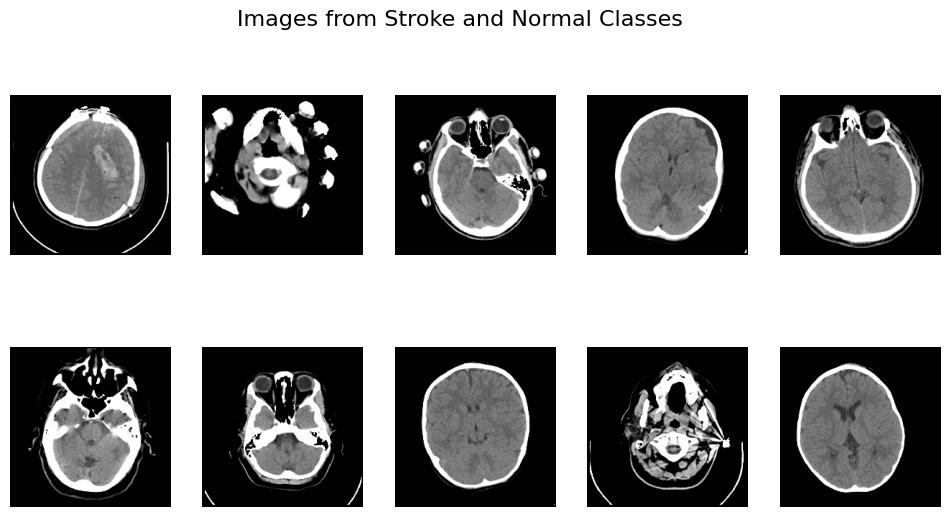

In [14]:
import matplotlib.pyplot as plt
import random

def display_sample_images(stroke_data, normal_data, num_samples=5):
    
    stroke_img_list = os.listdir(stroke_data)
    normal_img_list = os.listdir(normal_data)
    
    stroke_samples = random.sample(stroke_img_list, num_samples)
    normal_samples = random.sample(normal_img_list, num_samples)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))
    fig.suptitle('Images from Stroke and Normal Classes', fontsize=16)
    
    for i, img_name in enumerate(stroke_samples):
        img_path = os.path.join(stroke_data, img_name)
        img = load_img(img_path, target_size=(224, 224))
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title('Stroke')
    
    for i, img_name in enumerate(normal_samples):
        img_path = os.path.join(normal_data, img_name)
        img = load_img(img_path, target_size=(224, 224))
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        axes[1, i].set_title('Normal')

    plt.show()

display_sample_images(stroke_data, normal_data)

In [32]:
import cv2
import os
import numpy as np

# Directory containing the dataset
ds = '/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised'

# Image size to resize the images
img_size = (224, 224)

# Directory to save the preprocessed images
output_dir = '/kaggle/working/preprocessed_dataset'  # Folder where all preprocessed images will be stored

# Create the output directory and subfolders (if they don't exist)
normal_dir = os.path.join(output_dir, 'Normal')
stroke_dir = os.path.join(output_dir, 'Stroke')

if not os.path.exists(normal_dir):
    os.makedirs(normal_dir)

if not os.path.exists(stroke_dir):
    os.makedirs(stroke_dir)

# Preprocessing function to resize and normalize images
def preprocess_image(image_path, target_size=(224, 224)):
    # Load image
    image = cv2.imread(image_path)
    
    # Resize the image
    image = cv2.resize(image, target_size)
    
    # Normalize the image to [0, 1] range
    image = image / 255.0
    
    return image

# Function to apply preprocessing to all images and save them in corresponding folders
def preprocess_and_save_dataset(dataset_dir, normal_dir, stroke_dir):
    image_count = 0
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        
        # Ensure the directory contains images (skip if it's empty)
        if not os.path.isdir(class_dir):
            continue
        
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            # Preprocess the image
            preprocessed_image = preprocess_image(image_path, target_size=img_size)
            
            # Define the output path based on the class (normal or stroke)
            if class_name == 'Normal':
                output_image_path = os.path.join(normal_dir, image_file)
            elif class_name == 'Stroke':
                output_image_path = os.path.join(stroke_dir, image_file)
            else:
                continue  # Skip if the class is neither normal nor stroke
            
            # Convert image back to 0-255 range for saving
            preprocessed_image = (preprocessed_image * 255).astype(np.uint8)
            
            # Save the preprocessed image
            cv2.imwrite(output_image_path, preprocessed_image)
            image_count += 1
    
    print(f"Total {image_count} images have been preprocessed and saved to {output_dir}")

# Apply preprocessing and save the images in the respective folders
preprocess_and_save_dataset(ds, normal_dir, stroke_dir)


Total 2501 images have been preprocessed and saved to /kaggle/working/preprocessed_dataset


In [33]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

# Define directories
base_dir = '/kaggle/working/balanced'
stroke_data = '/kaggle/working/preprocessed_dataset/Stroke'
normal_data = '/kaggle/working/preprocessed_dataset/Normal'

# Create directories for balanced dataset
stroke_dir = os.path.join(base_dir, 'Stroke')
normal_dir = os.path.join(base_dir, 'Normal')

os.makedirs(stroke_dir, exist_ok=True)
os.makedirs(normal_dir, exist_ok=True)

# Function to copy files from source directory to destination directory
def copy_files(file_list, src_dir, dest_dir):
    for filename in file_list:
        dest_path = os.path.join(dest_dir, filename)
        if not os.path.exists(dest_path):
            src = os.path.join(src_dir, filename)
            shutil.copy(src, dest_path)

# Get the list of image files in both source directories
normal_files = os.listdir(normal_data)
stroke_files = os.listdir(stroke_data)

# Copy the normal and stroke images using the copy_files function
copy_files(normal_files, normal_data, normal_dir)
copy_files(stroke_files, stroke_data, stroke_dir)

# Count the number of images in each class
normal_images = len(os.listdir(normal_dir))
stroke_images = len(os.listdir(stroke_dir))

# Calculate the number of augmented images needed
no_of_aug_img = normal_images - stroke_images
no_of_aug_img_count = no_of_aug_img

print(f"Normal images: {normal_images}, Stroke images: {stroke_images}")
print(f"Number of augmented images needed: {no_of_aug_img_count}")

# If augmentation is needed, use ImageDataGenerator
if no_of_aug_img_count > 0:
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        fill_mode='nearest'
    )

    # Augment the stroke images
    i = 0  # Counter for augmented images
    for img_file in os.listdir(stroke_dir):
        if i >= no_of_aug_img_count:
            break
        img_path = os.path.join(stroke_dir, img_file)
        img = load_img(img_path)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Generate augmented images
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=stroke_dir, save_prefix="augmented", save_format='png'):
            i += 1
            if i >= no_of_aug_img_count:
                break

    print(f"Augmentation completed. {i} augmented images created.")


Normal images: 1551, Stroke images: 1532
Number of augmented images needed: 19
Augmentation completed. 19 augmented images created.


In [34]:
working_dir = '/kaggle/working/'
TTV_dir = os.path.join(working_dir, 'TTV')
train_dir = os.path.join(TTV_dir, 'train')
val_dir = os.path.join(TTV_dir, 'validation')
test_dir = os.path.join(TTV_dir, 'test')

for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(folder, 'stroke'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'normal'), exist_ok=True)

normal_dir = '/kaggle/working/balanced/Normal'
stroke_dir = '/kaggle/working/balanced/Stroke'
normal_images = os.listdir(normal_dir)
stroke_images = os.listdir(stroke_dir)

train_stroke, temp_stroke = train_test_split(stroke_images, test_size=0.3, random_state=42)
val_stroke, test_stroke = train_test_split(temp_stroke, test_size=0.5, random_state=42)

train_normal, temp_normal = train_test_split(normal_images, test_size=0.3, random_state=42)
val_normal, test_normal = train_test_split(temp_normal, test_size=0.5, random_state=42)

copy_files(train_stroke, stroke_dir, os.path.join(train_dir, 'stroke'))
copy_files(val_stroke, stroke_dir, os.path.join(val_dir, 'stroke'))
copy_files(test_stroke, stroke_dir, os.path.join(test_dir, 'stroke'))

copy_files(train_normal, normal_dir, os.path.join(train_dir, 'normal'))
copy_files(val_normal, normal_dir, os.path.join(val_dir, 'normal'))
copy_files(test_normal, normal_dir, os.path.join(test_dir, 'normal'))

print("Data split into training, validation, and test sets.")
print()
print(f"train normal images: {len(train_normal)}")
print(f"train stroke images: {len(train_stroke)}")
print()
print(f"val normal images: {len(val_normal)}")
print(f"val stroke images: {len(val_stroke)}")
print()
print(f"test normal images: {len(test_normal)}")
print(f"test stroke images: {len(test_stroke)}")

Data split into training, validation, and test sets.

train normal images: 1085
train stroke images: 1085

test normal images: 233
test stroke images: 233

val normal images: 233
val stroke images: 232


In [35]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    os.path.join(TTV_dir, 'train'),
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

validation_generator = datagen.flow_from_directory(
    os.path.join(TTV_dir, 'validation'),
    target_size=(224, 224),
    batch_size=64,
    shuffle=False,
    class_mode='binary'
)


test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    os.path.join(TTV_dir, 'test'),
    target_size=(224, 224),  
    batch_size=64,
    class_mode='binary',  
    shuffle=False,  
    classes=['normal', 'stroke']
)

Found 2474 images belonging to 2 classes.
Found 656 images belonging to 2 classes.
Found 657 images belonging to 2 classes.


In [36]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print("Model summary:")
# model.summary()

In [37]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 428ms/step - accuracy: 0.6030 - loss: 1.0043 - val_accuracy: 0.6098 - val_loss: 0.6260
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.6572 - loss: 0.6732 - val_accuracy: 0.7027 - val_loss: 0.4812
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.7204 - loss: 0.5090 - val_accuracy: 0.6524 - val_loss: 0.5258
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.7324 - loss: 0.4822 - val_accuracy: 0.7165 - val_loss: 0.4664
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.7556 - loss: 0.4423 - val_accuracy: 0.7744 - val_loss: 0.4175
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.7886 - loss: 0.4164 - val_accuracy: 0.7912 - val_loss: 0.3886
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.8044 - loss: 0.3913 - val_accuracy: 0.8308 - val_loss: 0.3773
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8308 - loss: 0.3566 - val_accuracy: 0.8476 - val

In [38]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - accuracy: 0.9621 - loss: 0.1239
Test Loss: 0.13420718908309937
Test Accuracy: 0.9573820233345032


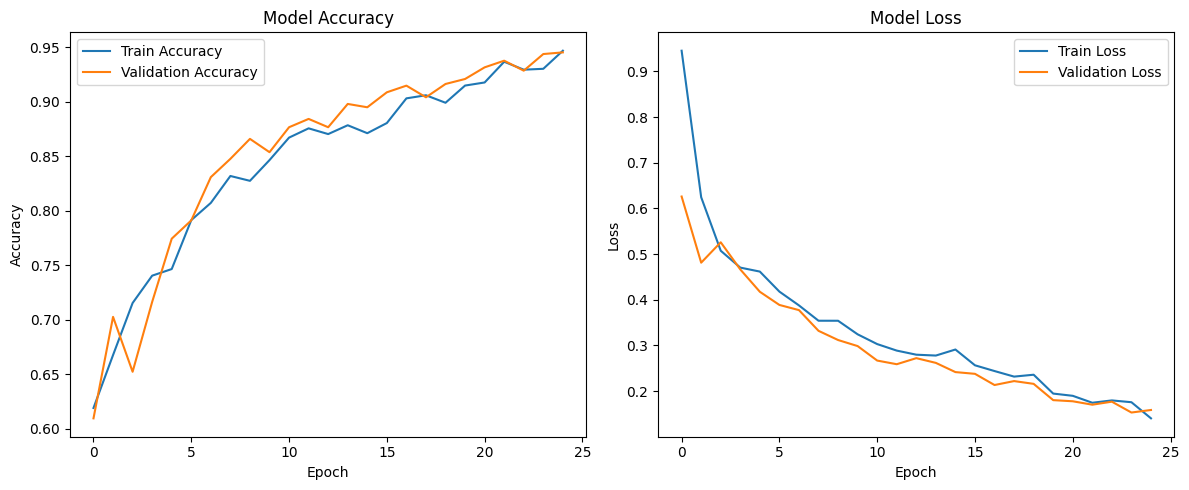

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [40]:
model_2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_2.trainable = False

model_VGG16 = Sequential([
    model_2,
    Flatten(),
    Dense(256, activation='relu'), 
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_VGG16.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Model summary:")
model_VGG16.summary()

history_2 = model_VGG16.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    
)

Model summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 541ms/step - accuracy: 0.5721 - loss: 0.7795 - val_accuracy: 0.6860 - val_loss: 0.4878
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.7861 - loss: 0.4325 - val_accuracy: 0.8399 - val_loss: 0.3734
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.8443 - loss: 0.3666 - val_accuracy: 0.8689 - val_loss: 0.3276
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.8704 - loss: 0.3101 - val_accuracy: 0.8796 - val_loss: 0.3049
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.9000 - loss: 0.2761 - val_accuracy: 0.9055 - val_loss: 0.2617
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.9212 - loss: 0.2349 - val_accuracy: 0.9116 - val_loss: 0.2383
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.9368 - loss: 0.2005 - val_accuracy: 0.9405 - val_loss: 0.2097
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.9416 - loss: 0.1883 - val_accuracy: 0

In [41]:
test_loss, test_accuracy = model_VGG16.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - accuracy: 0.9677 - loss: 0.0960
Test Loss: 0.08044019341468811
Test Accuracy: 0.9710806608200073


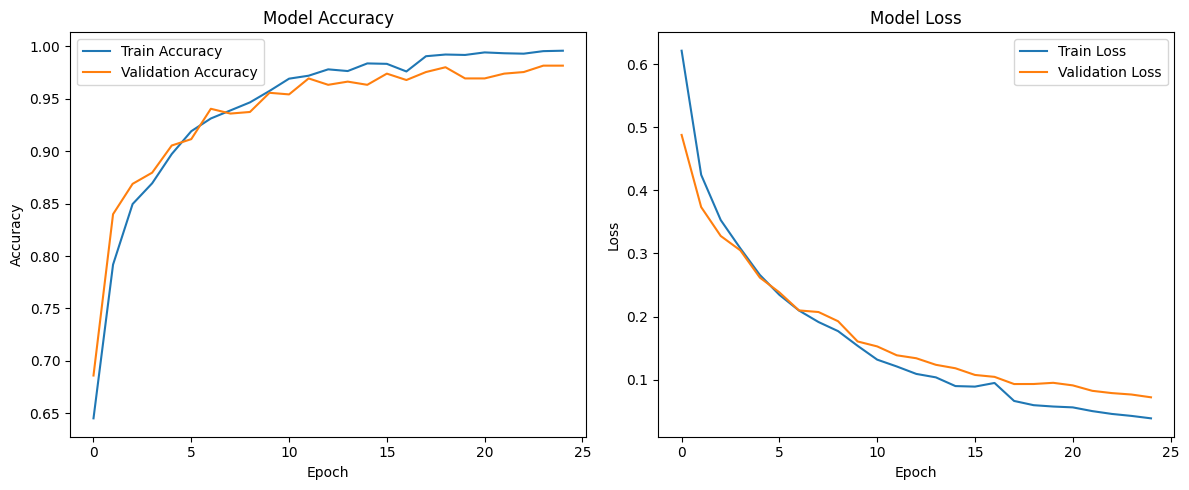

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [43]:
model_3 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_3.trainable = False

model_VGG19 = Sequential([
    model_3,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_VGG19.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Model summary:")
model_VGG19.summary()

history_3 = model_VGG19.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

Model summary:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,447,425 (100.89 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - accuracy: 0.6043 - loss: 0.6842 - val_accuracy: 0.7058 - val_loss: 0.4745
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.7651 - loss: 0.4493 - val_accuracy: 0.8018 - val_loss: 0.3958
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.8199 - loss: 0.3819 - val_accuracy: 0.7683 - val_loss: 0.3980
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.8500 - loss: 0.3433 - val_accuracy: 0.8308 - val_loss: 0.3375
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.8808 - loss: 0.2951 - val_accuracy: 0.8643 - val_loss: 0.3067
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.8893 - loss: 0.2715 - val_accuracy: 0.8384 - val_loss: 0.3085
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.8986 - loss: 0.2517 - val_accuracy: 0.9116 - val_loss: 0.2377
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.9049 - loss: 0.2396 - val_accuracy: 0

In [60]:
test_loss, test_accuracy = model_VGG19.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9818 - loss: 0.0869
Test Loss: 0.0834493637084961
Test Accuracy: 0.9802131056785583


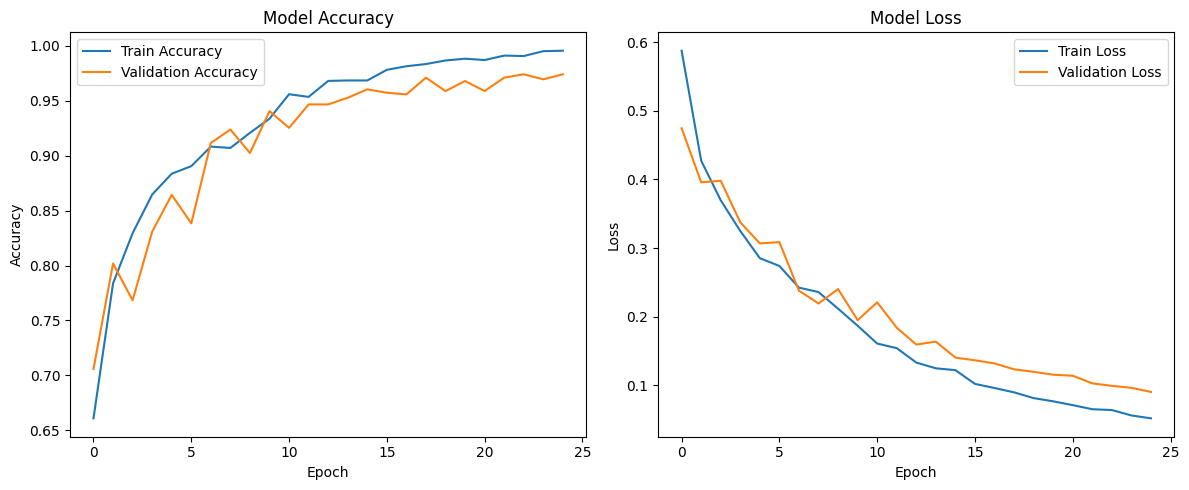

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [46]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet121 model
model_4 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_4.trainable = False  # Freeze the DenseNet121 layers

# Build the model
model_DenseNet121 = Sequential([
    model_4,
    Flatten(), 
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_DenseNet121.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

# Print model summary
print("Model summary:")
model_DenseNet121.summary()

# Fit the model on training data
history_4 = model_DenseNet121.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)


Model summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,883,073 (75.85 MB)

 Trainable params: 12,845,569 (49.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 49s 808ms/step - accuracy: 0.6214 - loss: 1.5832 - val_accuracy: 0.8232 - val_loss: 0.4115
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.7962 - loss: 0.4064 - val_accuracy: 0.8415 - val_loss: 0.3376
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.8489 - loss: 0.3265 - val_accuracy: 0.8948 - val_loss: 0.2761
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.8981 - loss: 0.2635 - val_accuracy: 0.8765 - val_loss: 0.2557
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9082 - loss: 0.2252 - val_accuracy: 0.9253 - val_loss: 0.2266
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.9206 - loss: 0.2132 - val_accuracy: 0.9207 - val_loss: 0.1999
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.9446 - loss: 0.1554 - val_accuracy: 0.9405 - val_loss: 0.1659
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9418 - loss: 0.1518 - val_accuracy: 0

In [47]:
test_loss, test_accuracy = model_DenseNet121.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 868ms/step - accuracy: 0.9813 - loss: 0.0523
Test Loss: 0.04024447128176689
Test Accuracy: 0.9863013625144958


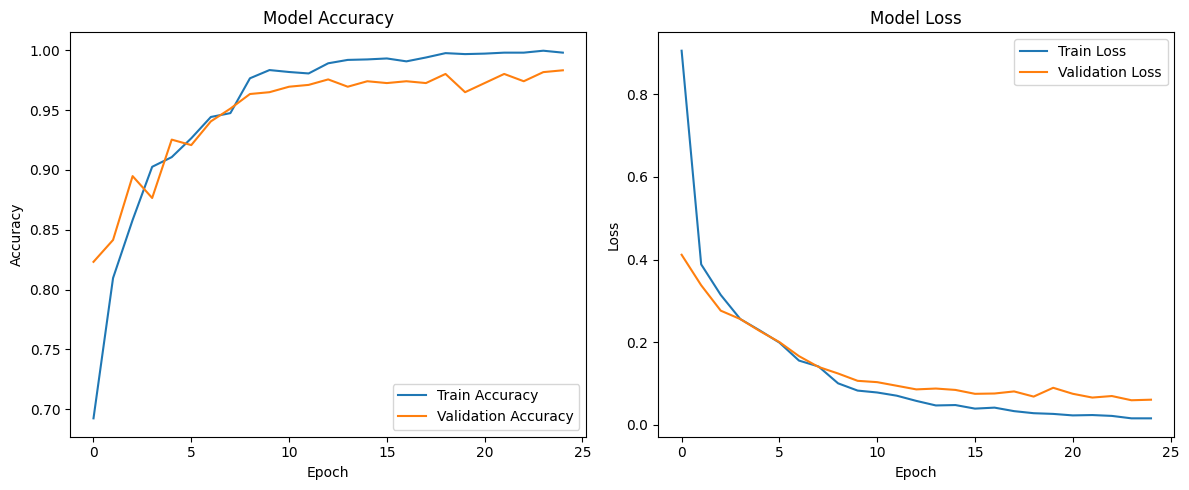

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_4.history['accuracy'], label='Train Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(history_4.history['loss'], label='Train Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


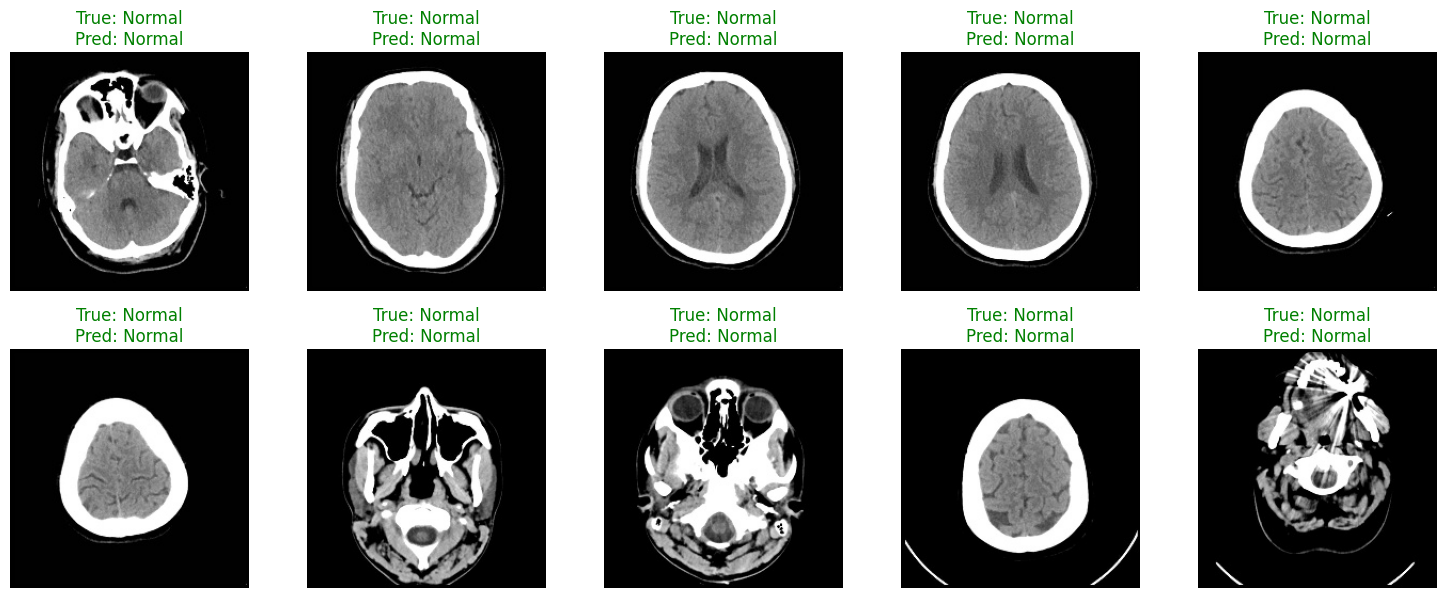

In [49]:
import matplotlib.pyplot as plt
import numpy as np

test_images, true_labels = next(test_generator)  
predictions = model_DenseNet121.predict(test_images)
predicted_labels = np.round(predictions).astype(int) 

class_names = ['Normal', 'Stroke']

num_images = 10 
plt.figure(figsize=(15, 15))

for i in range(num_images):
    ax = plt.subplot(5, 5, i + 1) 
    plt.imshow(test_images[i])
    true_label = class_names[int(true_labels[i])]  
    predicted_label = class_names[int(predicted_labels[i][0])]  

    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=("green" if true_label == predicted_label else "red"))
    plt.axis("off")

plt.tight_layout()
plt.show()


In [50]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Define Bayesian Dense Layer
class BayesianDense(tf.keras.layers.Layer):
    def __init__(self, units, prior_stddev=1.0, activation=None):
        super(BayesianDense, self).__init__()
        self.units = units
        self.prior_stddev = prior_stddev
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # Variational parameters for weights and biases
        self.w_mu = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
            name="w_mu"
        )
        self.w_rho = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
            name="w_rho"
        )
        self.b_mu = self.add_weight(
            shape=(self.units,),
            initializer="random_normal",
            trainable=True,
            name="b_mu"
        )
        self.b_rho = self.add_weight(
            shape=(self.units,),
            initializer="random_normal",
            trainable=True,
            name="b_rho"
        )

    def call(self, inputs, training=False):
        # Compute weights and biases using reparameterization trick
        w_sigma = tf.nn.softplus(self.w_rho)
        b_sigma = tf.nn.softplus(self.b_rho)
        weights = self.w_mu + w_sigma * tf.random.normal(shape=self.w_mu.shape)
        biases = self.b_mu + b_sigma * tf.random.normal(shape=self.b_mu.shape)

        output = tf.matmul(inputs, weights) + biases
        if self.activation:
            output = self.activation(output)
        return output

# Define Bayesian Network
def create_bayesian_model(input_shape):
    model = Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        BayesianDense(256, activation='relu'),
        layers.Dropout(0.5),
        BayesianDense(128, activation='relu'),
        layers.Dropout(0.5),
        BayesianDense(1, activation='sigmoid')
    ])
    return model


In [51]:
# Model Compilation and Data Generators
input_shape = (224, 224, 3)
model_bnn = create_bayesian_model(input_shape)
model_bnn.compile(optimizer=SGD(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the Bayesian Neural Network
history_bnn = model_bnn.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
)

Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 409ms/step - accuracy: 0.4942 - loss: 7197.1948 - val_accuracy: 0.6845 - val_loss: 4850.7061
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.4994 - loss: 4930.5356 - val_accuracy: 0.6128 - val_loss: 2631.2283
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.5145 - loss: 3190.5381 - val_accuracy: 0.4634 - val_loss: 1574.8413
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.5050 - loss: 2000.8494 - val_accuracy: 0.6235 - val_loss: 688.2680
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.5241 - loss: 1469.7454 - val_accuracy: 0.7027 - val_loss: 159.5894
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.4945 - loss: 991.9875 - val_accuracy: 0.6082 - val_loss: 194.8323
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.4987 - loss: 522.0198 - val_accuracy: 0.4055 - val_loss: 154.0716
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.5

In [52]:
# Evaluate the Model
test_loss, test_accuracy = model_bnn.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.5776 - loss: 63.4039
Test Loss: 49.39639663696289
Test Accuracy: 0.6301369667053223


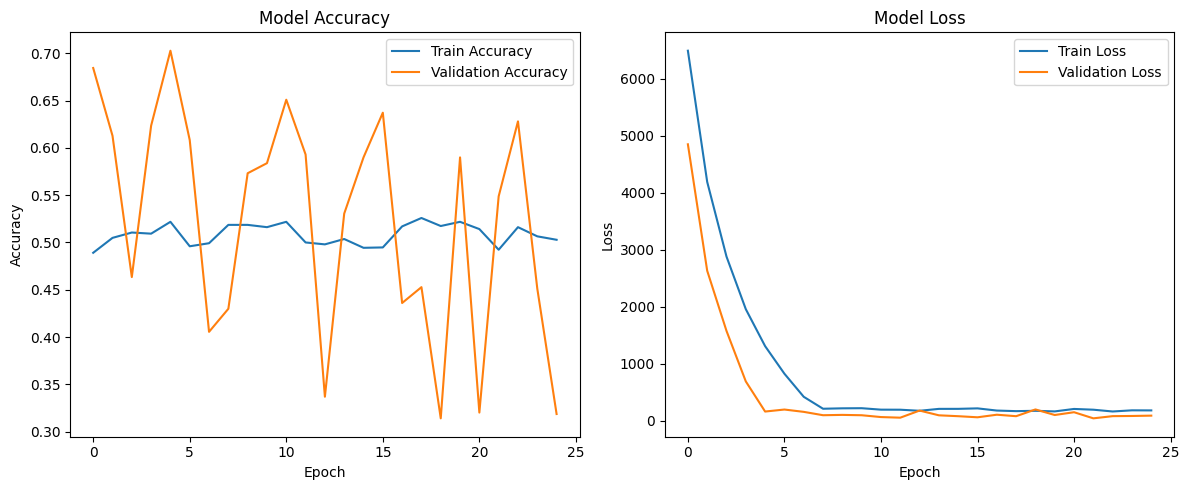

In [53]:
# Plot Training and Validation Metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_bnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_bnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(history_bnn.history['loss'], label='Train Loss')
plt.plot(history_bnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

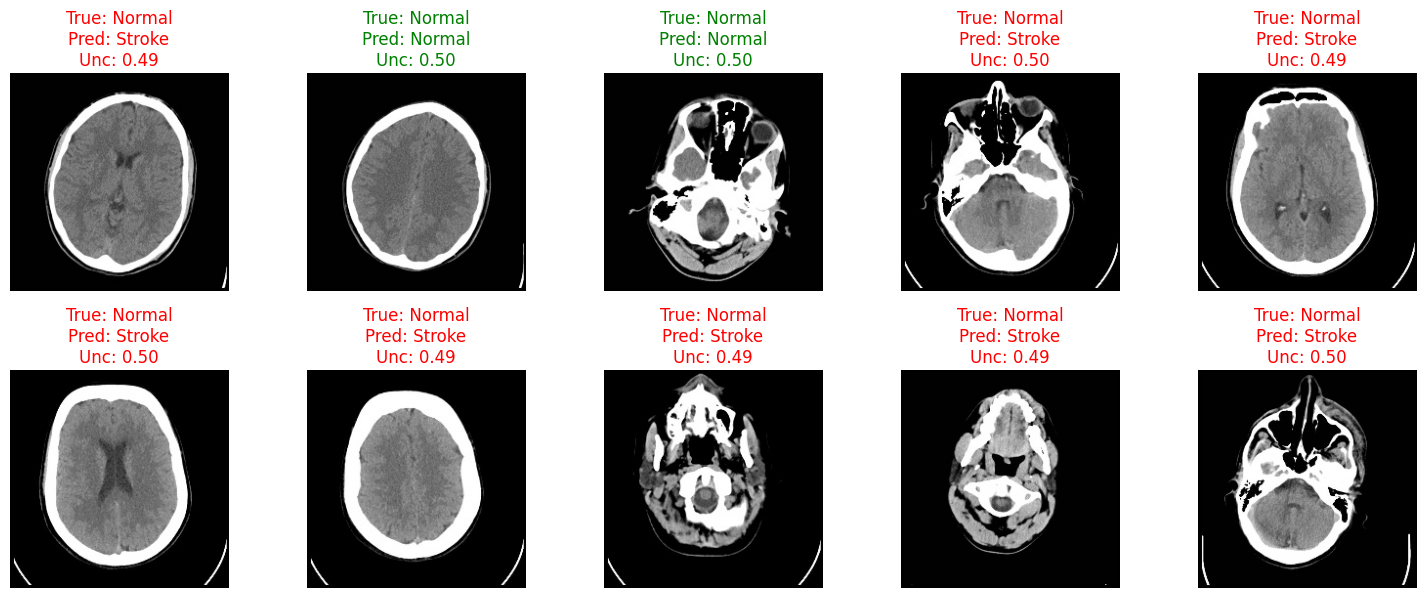

In [54]:
# Predict on Test Data with Uncertainty
test_images, true_labels = next(test_generator)
predictions = np.array([model_bnn(test_images, training=True) for _ in range(100)])  # T samples
mean_predictions = predictions.mean(axis=0).squeeze()
std_predictions = predictions.std(axis=0).squeeze()

predicted_labels = np.round(mean_predictions).astype(int)

# Display Predictions with Uncertainty
num_images = 10
plt.figure(figsize=(15, 15))

for i in range(num_images):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    true_label = class_names[int(true_labels[i])]
    predicted_label = class_names[int(predicted_labels[i])]
    uncertainty = std_predictions[i]

    plt.title(f"True: {true_label}\nPred: {predicted_label}\nUnc: {uncertainty:.2f}",
              color=("green" if true_label == predicted_label else "red"))
    plt.axis("off")

plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step

Model: ResNet50
AUC: 0.9913
Precision: 0.9825
Recall (Sensitivity): 0.9314
Specificity: 0.9700
F1 Score: 0.9563

Classification Report:
              precision    recall  f1-score   support

      normal       0.89      0.97      0.93       233
      stroke       0.98      0.93      0.96       423

    accuracy                           0.95       656
   macro avg       0.93      0.95      0.94       656
weighted avg       0.95      0.95      0.95       656

Confusion Matrix:
[[226   7]
 [ 29 394]]
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step

Model: VGG16
AUC: 0.9980
Precision: 0.9768
Recall (Sensitivity): 0.9953
Specificity: 0.9571
F1 Score: 0.9859

Classification Report:
              precision    recall  f1-score   support

      normal       0.99      0.96      0.97       233
      stroke       0.98      1.00      0.99       423

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighte

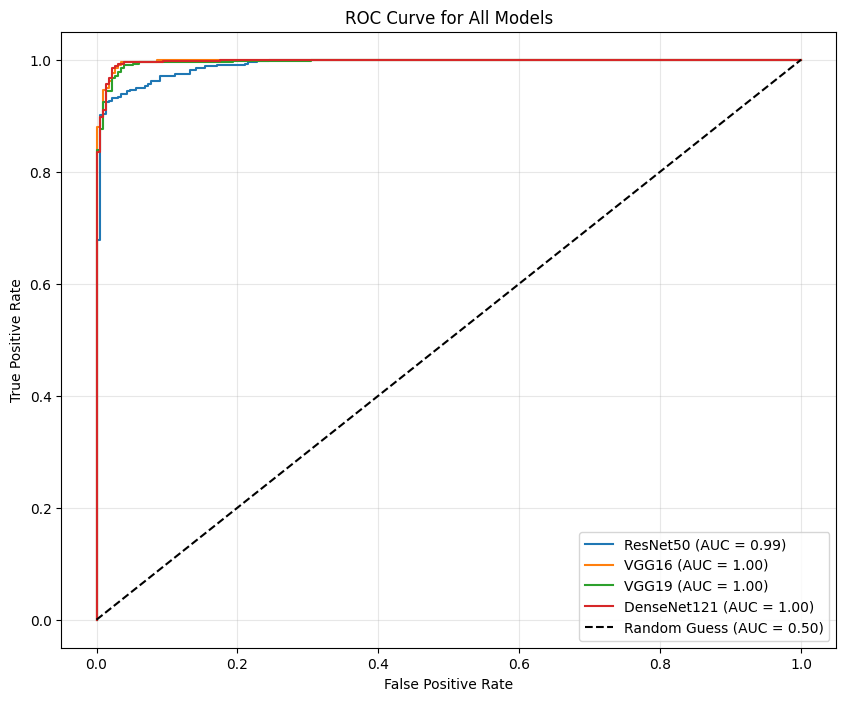

In [64]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Function to plot ROC curve and calculate metrics
def evaluate_model(model, generator, model_name):
    # Ensure the generator does not shuffle data
    assert not generator.shuffle, "Set shuffle=False in the generator for consistency."
    
    # Get true labels and predicted probabilities
    y_true = generator.classes  # True labels (0/1)
    y_pred_prob = model.predict(generator).ravel()  # Predicted probabilities (flattened)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Binary predictions (0 or 1)

    # Compute ROC metrics
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate additional metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall = Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print metrics
    print(f"\nModel: {model_name}")
    print(f"AUC: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"\nClassification Report:\n{classification_report(y_true, y_pred, target_names=generator.class_indices.keys())}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    return fpr, tpr, roc_auc, model_name

# Create a figure for the ROC curves
plt.figure(figsize=(10, 8))

# Evaluate ResNet50
fpr_resnet, tpr_resnet, auc_resnet, name_resnet = evaluate_model(model, validation_generator, "ResNet50")
plt.plot(fpr_resnet, tpr_resnet, label=f'{name_resnet} (AUC = {auc_resnet:.2f})')

# Evaluate VGG16
fpr_vgg16, tpr_vgg16, auc_vgg16, name_vgg16 = evaluate_model(model_VGG16, validation_generator, "VGG16")
plt.plot(fpr_vgg16, tpr_vgg16, label=f'{name_vgg16} (AUC = {auc_vgg16:.2f})')

# Evaluate VGG19
fpr_vgg19, tpr_vgg19, auc_vgg19, name_vgg19 = evaluate_model(model_VGG19, validation_generator, "VGG19")
plt.plot(fpr_vgg19, tpr_vgg19, label=f'{name_vgg19} (AUC = {auc_vgg19:.2f})')

# Evaluate DenseNet121
fpr_densenet, tpr_densenet, auc_densenet, name_densenet = evaluate_model(model_DenseNet121, validation_generator, "DenseNet121")
plt.plot(fpr_densenet, tpr_densenet, label=f'{name_densenet} (AUC = {auc_densenet:.2f})')

# Add a random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')

# Finalize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Models')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


In [56]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to calculate RMSE
def calculate_rmse(model, validation_generator, model_name):
    y_true = validation_generator.classes  # True labels
    y_pred_prob = model.predict(validation_generator).flatten()  # Predicted probabilities
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_prob))
    print(f"RMSE for {model_name}: {rmse:.4f}")

# RMSE for ResNet50
calculate_rmse(model, validation_generator, "ResNet50")

# RMSE for VGG16
calculate_rmse(model_VGG16, validation_generator, "VGG16")

# RMSE for VGG19
calculate_rmse(model_VGG19, validation_generator, "VGG19")

# RMSE for DenseNet121
calculate_rmse(model_DenseNet121, validation_generator, "DenseNet121")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
RMSE for ResNet50: 0.2145
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
RMSE for VGG16: 0.1325
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
RMSE for VGG19: 0.1482
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
RMSE for DenseNet121: 0.1263


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


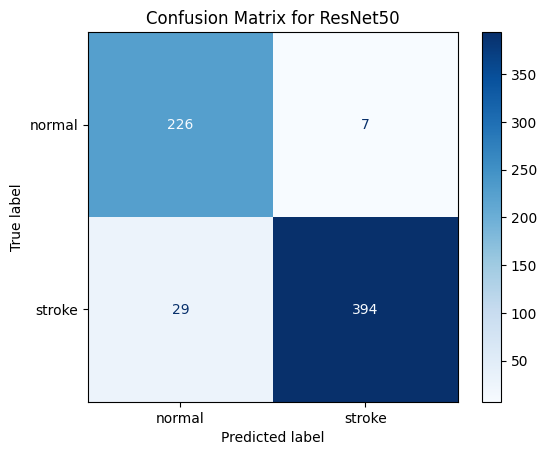

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


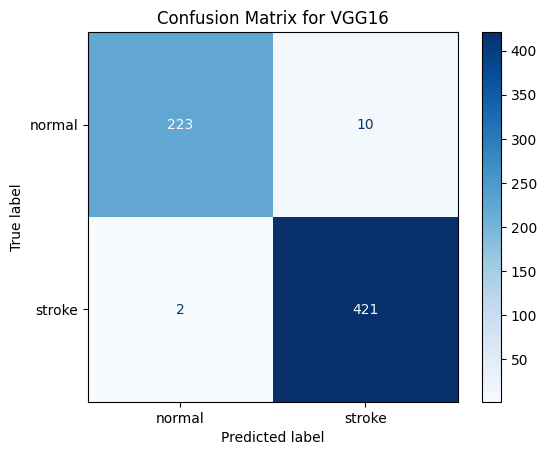

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step


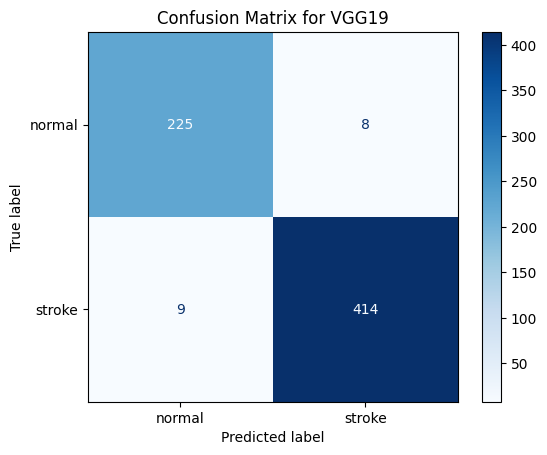

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


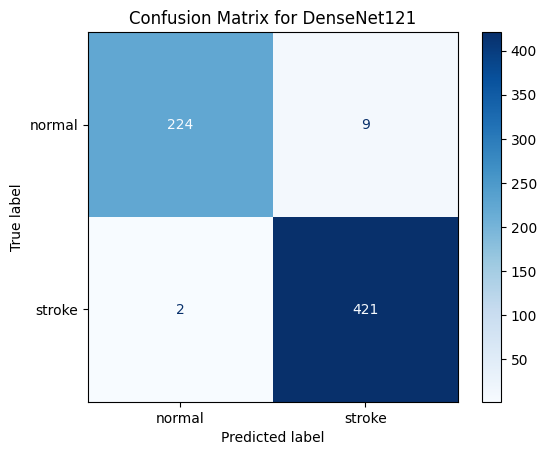

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to display confusion matrix
def plot_confusion_matrix(model, validation_generator, model_name):
    y_true = validation_generator.classes  # True labels
    y_pred_prob = model.predict(validation_generator).flatten()  # Predicted probabilities
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Confusion Matrix for ResNet50
plot_confusion_matrix(model, validation_generator, "ResNet50")

# Confusion Matrix for VGG16
plot_confusion_matrix(model_VGG16, validation_generator, "VGG16")

# Confusion Matrix for VGG19
plot_confusion_matrix(model_VGG19, validation_generator, "VGG19")

# Confusion Matrix for DenseNet121
plot_confusion_matrix(model_DenseNet121, validation_generator, "DenseNet121")


In [59]:
model.save('model_ResNet50.h5')
model_VGG16.save('model_VGG16.h5')
model_VGG19.save('model_VGG19.h5')
model_DenseNet121.save('model_DenseNet121.h5')
# model_bnn.save('model_bnn.h5')